In [1]:
#!pip install textblob

In [2]:
#!python -m textblob.download_corpora

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from nltk.classify import NaiveBayesClassifier

In [4]:
# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is alr

In [5]:
import chardet

rawdata= open('Elon_musk.csv','rb').read()

result=chardet.detect(rawdata)

encoding=result['encoding']

df=pd.read_csv('Elon_musk.csv',encoding=encoding,index_col=0)
df

,Text
1,@kunalb11 I’m an alien
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
3,@joerogan @Spotify Great interview!
4,@gtera27 Doge is underestimated
5,@teslacn Congratulations Tesla China for amazi...
...,...
1995,"@flcnhvy True, it sounds so surreal, but the n..."
1996,@PPathole Make sure to read ur terms &amp; con...
1997,@TeslaGong @PPathole Samwise Gamgee
1998,@PPathole Altho Dumb and Dumber is <U+0001F525...


# Removing '@names'

In [6]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [7]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
df['tidy_tweets'] = np.vectorize(remove_pattern)(df['Text'], "@[\w]*")
df

,Text,tidy_tweets
1,@kunalb11 I’m an alien,I’m an alien
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-lev...
3,@joerogan @Spotify Great interview!,Great interview!
4,@gtera27 Doge is underestimated,Doge is underestimated
5,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execu...
...,...,...
1995,"@flcnhvy True, it sounds so surreal, but the n...","True, it sounds so surreal, but the negative ..."
1996,@PPathole Make sure to read ur terms &amp; con...,Make sure to read ur terms &amp; conditions b...
1997,@TeslaGong @PPathole Samwise Gamgee,Samwise Gamgee
1998,@PPathole Altho Dumb and Dumber is <U+0001F525...,Altho Dumb and Dumber is <U+0001F525><U+0001F...


# Removing links (http | https)

In [8]:
cleaned_tweets = []

for index, row in df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

df['tidy_tweets'] = cleaned_tweets
df

,Text,tidy_tweets
1,@kunalb11 I’m an alien,I’m an alien
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
3,@joerogan @Spotify Great interview!,Great interview!
4,@gtera27 Doge is underestimated,Doge is underestimated
5,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
...,...,...
1995,"@flcnhvy True, it sounds so surreal, but the n...","True, it sounds so surreal, but the negative p..."
1996,@PPathole Make sure to read ur terms &amp; con...,Make sure to read ur terms &amp; conditions be...
1997,@TeslaGong @PPathole Samwise Gamgee,Samwise Gamgee
1998,@PPathole Altho Dumb and Dumber is <U+0001F525...,Altho Dumb and Dumber is <U+0001F525><U+0001F525>


In [9]:
# Convert all strings in the 'tidy_tweets' column to lowercase
df['tidy_tweets'] = df['tidy_tweets'].str.lower()
df

,Text,tidy_tweets
1,@kunalb11 I’m an alien,i’m an alien
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is next-leve...
3,@joerogan @Spotify Great interview!,great interview!
4,@gtera27 Doge is underestimated,doge is underestimated
5,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...
...,...,...
1995,"@flcnhvy True, it sounds so surreal, but the n...","true, it sounds so surreal, but the negative p..."
1996,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms &amp; conditions be...
1997,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee
1998,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is <u+0001f525><u+0001f525>


# Using NLTK's SentimentIntensityAnalyzer 

In [10]:
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

In [11]:
sentiments_using_SIA = df['tidy_tweets'].apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,tidy_tweets
pos,1770
neg,229


In [12]:
df['sentiment']=sentiments_using_SIA
df

,Text,tidy_tweets,sentiment
1,@kunalb11 I’m an alien,i’m an alien,pos
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is next-leve...,pos
3,@joerogan @Spotify Great interview!,great interview!,pos
4,@gtera27 Doge is underestimated,doge is underestimated,neg
5,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,pos
...,...,...,...
1995,"@flcnhvy True, it sounds so surreal, but the n...","true, it sounds so surreal, but the negative p...",neg
1996,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms &amp; conditions be...,pos
1997,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee,pos
1998,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is <u+0001f525><u+0001f525>,neg


# Removing tweets with empty text

In [13]:
df = df[df['tidy_tweets']!='']
df

,Text,tidy_tweets,sentiment
1,@kunalb11 I’m an alien,i’m an alien,pos
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is next-leve...,pos
3,@joerogan @Spotify Great interview!,great interview!,pos
4,@gtera27 Doge is underestimated,doge is underestimated,neg
5,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,pos
...,...,...,...
1995,"@flcnhvy True, it sounds so surreal, but the n...","true, it sounds so surreal, but the negative p...",neg
1996,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms &amp; conditions be...,pos
1997,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee,pos
1998,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is <u+0001f525><u+0001f525>,neg


# Dropping duplicate rows

In [14]:
df.drop_duplicates(subset=['tidy_tweets'], keep=False)
df

,Text,tidy_tweets,sentiment
1,@kunalb11 I’m an alien,i’m an alien,pos
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is next-leve...,pos
3,@joerogan @Spotify Great interview!,great interview!,pos
4,@gtera27 Doge is underestimated,doge is underestimated,neg
5,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,pos
...,...,...,...
1995,"@flcnhvy True, it sounds so surreal, but the n...","true, it sounds so surreal, but the negative p...",neg
1996,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms &amp; conditions be...,pos
1997,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee,pos
1998,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is <u+0001f525><u+0001f525>,neg


# Resetting index

In [15]:
df = df.reset_index(drop=True)
df

,Text,tidy_tweets,sentiment
0,@kunalb11 I’m an alien,i’m an alien,pos
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is next-leve...,pos
2,@joerogan @Spotify Great interview!,great interview!,pos
3,@gtera27 Doge is underestimated,doge is underestimated,neg
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,pos
...,...,...,...
1946,"@flcnhvy True, it sounds so surreal, but the n...","true, it sounds so surreal, but the negative p...",neg
1947,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms &amp; conditions be...,pos
1948,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee,pos
1949,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is <u+0001f525><u+0001f525>,neg


# Removing Punctuations, Numbers and Special characters

In [16]:
df['absolute_tidy_tweets'] = df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")
df

C:\Users\rites\AppData\Local\Temp\ipykernel_24432\4218241724.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['absolute_tidy_tweets'] = df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


,Text,tidy_tweets,sentiment,absolute_tidy_tweets
0,@kunalb11 I’m an alien,i’m an alien,pos,im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is next-leve...,pos,ray tracing on cyberpunk with hdr is nextlevel...
2,@joerogan @Spotify Great interview!,great interview!,pos,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,neg,doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,pos,congratulations tesla china for amazing execut...
...,...,...,...,...
1946,"@flcnhvy True, it sounds so surreal, but the n...","true, it sounds so surreal, but the negative p...",neg,true it sounds so surreal but the negative pro...
1947,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms &amp; conditions be...,pos,make sure to read ur terms amp conditions befo...
1948,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee,pos,samwise gamgee
1949,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is <u+0001f525><u+0001f525>,neg,altho dumb and dumber is ufuf


# Removing Stop words

In [17]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
df['absolute_tidy_tweets'] = cleaned_tweets
df

,Text,tidy_tweets,sentiment,absolute_tidy_tweets
0,@kunalb11 I’m an alien,i’m an alien,pos,im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is next-leve...,pos,ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @Spotify Great interview!,great interview!,pos,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,neg,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,pos,congratulations tesla china amazing execution ...
...,...,...,...,...
1946,"@flcnhvy True, it sounds so surreal, but the n...","true, it sounds so surreal, but the negative p...",neg,true sounds surreal negative propaganda still ...
1947,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms &amp; conditions be...,pos,make sure read ur terms amp conditions clickin...
1948,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee,pos,samwise gamgee
1949,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is <u+0001f525><u+0001f525>,neg,altho dumb dumber ufuf


# Tokenize absolute_tidy_tweets

In [18]:
tokenized_tweet = df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet

0                                             [im, alien]
1        [ray, tracing, cyberpunk, hdr, nextlevel, tried]
2                                      [great, interview]
3                                  [doge, underestimated]
4       [congratulations, tesla, china, amazing, execu...
                              ...                        
1946    [true, sounds, surreal, negative, propaganda, ...
1947    [make, sure, read, ur, terms, amp, conditions,...
1948                                    [samwise, gamgee]
1949                          [altho, dumb, dumber, ufuf]
1950                           [progress, update, august]
Name: absolute_tidy_tweets, Length: 1951, dtype: object

In [19]:
# Lemmatization

In [20]:
word_lemmatizer = WordNetLemmatizer()

In [21]:
tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet

0                                             [im, alien]
1        [ray, tracing, cyberpunk, hdr, nextlevel, tried]
2                                      [great, interview]
3                                  [doge, underestimated]
4       [congratulation, tesla, china, amazing, execut...
                              ...                        
1946    [true, sound, surreal, negative, propaganda, s...
1947    [make, sure, read, ur, term, amp, condition, c...
1948                                    [samwise, gamgee]
1949                          [altho, dumb, dumber, ufuf]
1950                           [progress, update, august]
Name: absolute_tidy_tweets, Length: 1951, dtype: object

# Joining all tokens into sentences

In [22]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

df['absolute_tidy_tweets'] = tokenized_tweet
df

,Text,tidy_tweets,sentiment,absolute_tidy_tweets
0,@kunalb11 I’m an alien,i’m an alien,pos,im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is next-leve...,pos,ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @Spotify Great interview!,great interview!,pos,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,neg,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,pos,congratulation tesla china amazing execution l...
...,...,...,...,...
1946,"@flcnhvy True, it sounds so surreal, but the n...","true, it sounds so surreal, but the negative p...",neg,true sound surreal negative propaganda still a...
1947,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms &amp; conditions be...,pos,make sure read ur term amp condition clicking ...
1948,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee,pos,samwise gamgee
1949,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is <u+0001f525><u+0001f525>,neg,altho dumb dumber ufuf


# WordCloud

In [23]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

# Most common words in positive tweets

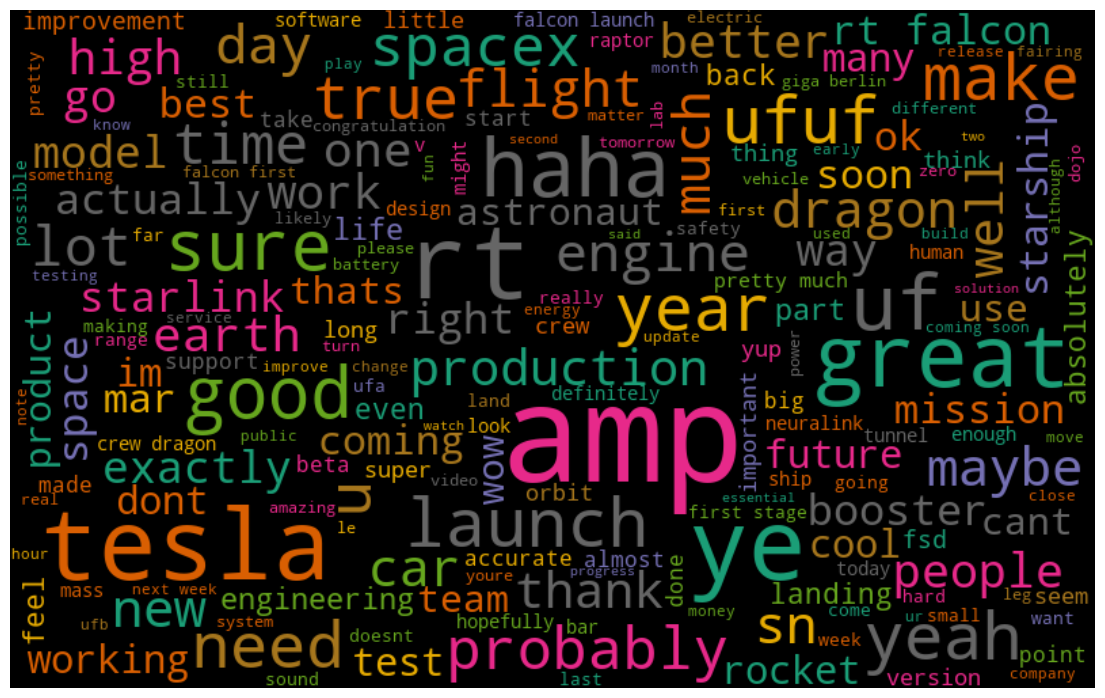

In [24]:
all_words = ' '.join([text for text in df['absolute_tidy_tweets'][df.sentiment == 'pos']])
generate_wordcloud(all_words)

# Most common words in negative tweets

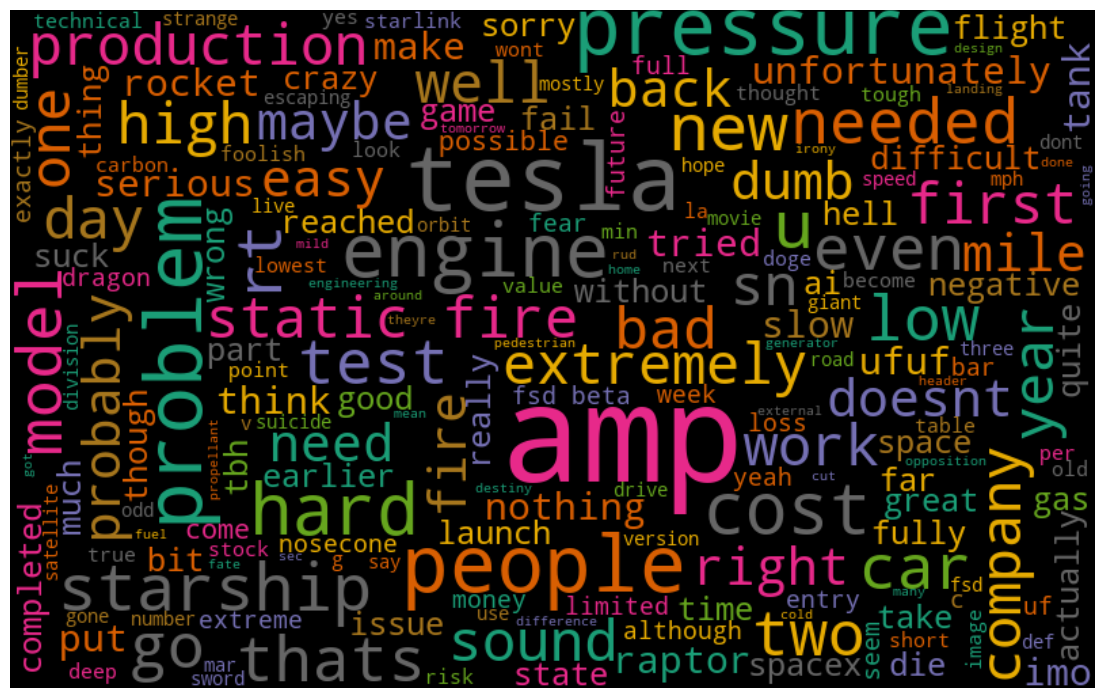

In [25]:
all_words = ' '.join([text for text in df['absolute_tidy_tweets'][df['sentiment'] == 'neg']])
generate_wordcloud(all_words)

# Most commonly used Hashtags

In [26]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [27]:
hashtags = hashtag_extract(df['tidy_tweets'])
hashtags = sum(hashtags, [])

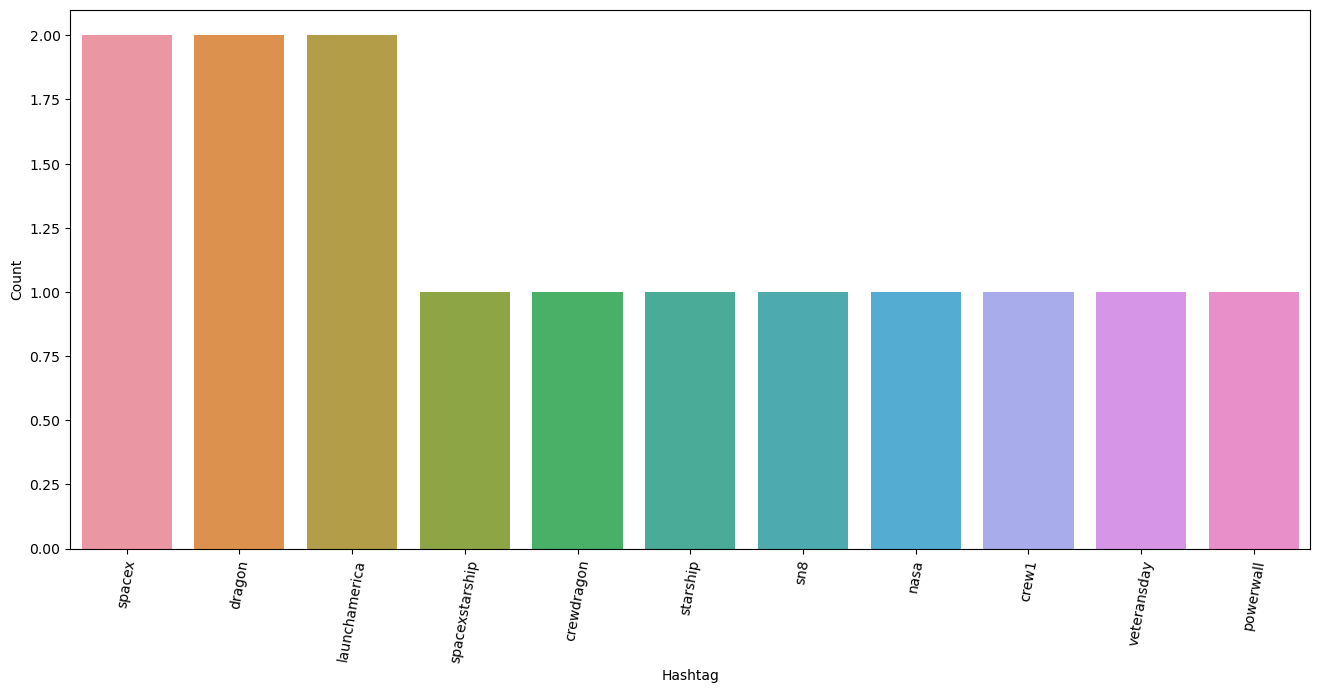

In [28]:
generate_hashtag_freqdist(hashtags)

# simple way to extract key phrases, by using TextBlob (ConllExtractor)

In [29]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in df.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.tidy_tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['’ m'],
 [],
 ['great interview'],
 [],
 ['congratulations tesla china', 'amazing execution last year'],
 ['happy new year'],
 [],
 [],
 ['real-world time allocation'],
 []]

In [30]:
df['key_phrases'] = textblob_key_phrases
df

,Text,tidy_tweets,sentiment,absolute_tidy_tweets,key_phrases
0,@kunalb11 I’m an alien,i’m an alien,pos,im alien,[’ m]
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is next-leve...,pos,ray tracing cyberpunk hdr nextlevel tried,[]
2,@joerogan @Spotify Great interview!,great interview!,pos,great interview,[great interview]
3,@gtera27 Doge is underestimated,doge is underestimated,neg,doge underestimated,[]
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,pos,congratulation tesla china amazing execution l...,"[congratulations tesla china, amazing executio..."
...,...,...,...,...,...
1946,"@flcnhvy True, it sounds so surreal, but the n...","true, it sounds so surreal, but the negative p...",neg,true sound surreal negative propaganda still a...,"[negative propaganda, social me…]"
1947,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms &amp; conditions be...,pos,make sure read ur term amp condition clicking ...,[]
1948,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee,pos,samwise gamgee,[]
1949,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is <u+0001f525><u+0001f525>,neg,altho dumb dumber ufuf,[]


In [31]:
# For sake of consistency, we are going to discard the records which contains no phrases i.e where df['key_phrases'] contains []
df2 = df[df['key_phrases'].str.len()>0]

In [32]:
df2

,Text,tidy_tweets,sentiment,absolute_tidy_tweets,key_phrases
0,@kunalb11 I’m an alien,i’m an alien,pos,im alien,[’ m]
2,@joerogan @Spotify Great interview!,great interview!,pos,great interview,[great interview]
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,pos,congratulation tesla china amazing execution l...,"[congratulations tesla china, amazing executio..."
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox!,pos,happy new year ox,[happy new year]
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed! tweets definitely do not represent rea...,pos,indeed tweet definitely represent realworld ti...,[real-world time allocation]
...,...,...,...,...,...
1938,Best use of the term “Full Stack”?,best use of the term “full stack”?,pos,best use term full stack,[full stack]
1939,@PPathole @IheartTesla For sure. This is both ...,for sure. this is both great &amp; terrifying....,pos,sure great amp terrifying everything weve ever...,[’ ve]
1942,"@kenyanwalstreet Not actually a payout, just a...","not actually a payout, just a vesting of stock...",pos,actually payout vesting stock option may never...,[’ t b…]
1943,@IheartTesla No easy way to answer this in a t...,"no easy way to answer this in a tweet, but hel...",neg,easy way answer tweet helping dire brain injur...,"[easy way, dire brain injuries, first priority]"


# Feature Extraction
We need to convert textual representation in the form on numeric features. We have two popular techniques to perform feature extraction:

1. Bag of words (Simple vectorization)
2. TF-IDF (Term Frequency - Inverse Document Frequency)

We will use extracted features from both one by one to perform sentiment analysis and will compare the result at last.

# A. Feature Extraction for 'Key Words'

In [37]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(df2['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(df2['absolute_tidy_tweets'])

# B. Feature Extraction for 'Key Phrases'

In [38]:
phrase_sents = df2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

# Model Building: Sentiment Analysis

# Map target variables to {0, 1}

In [39]:
target_variable = df2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [40]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

In [41]:
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

# A. Predictions on 'key words' based features

# a. BOW word features

Accuracy Score - 0.7285223367697594


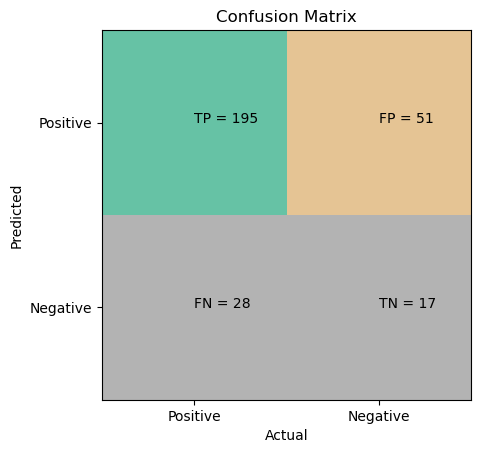

In [44]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

# b. TF-IDF word features

Accuracy Score - 0.7250859106529209


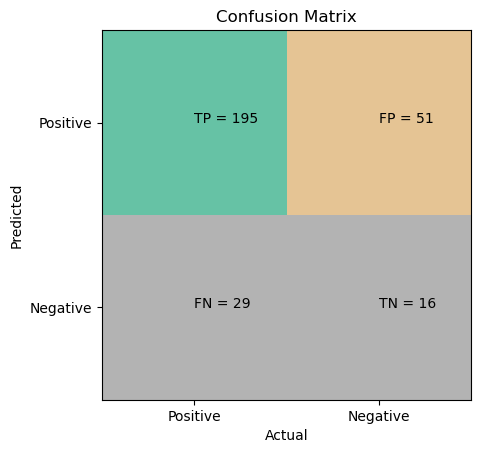

In [45]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

# B. Predictions on 'key phrases' based features

# a. BOW Phrase features

Accuracy Score - 0.5326460481099656


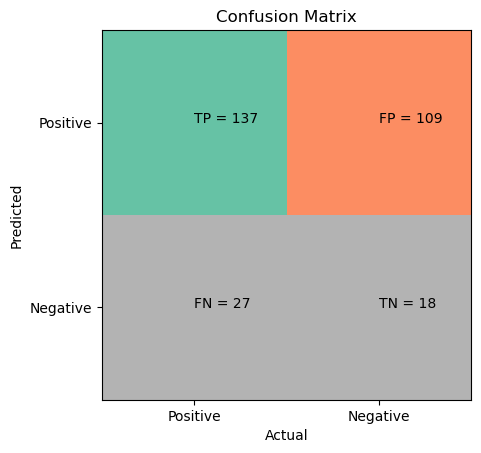

In [46]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

# b. TF-IDF Phrase features

Accuracy Score - 0.5360824742268041


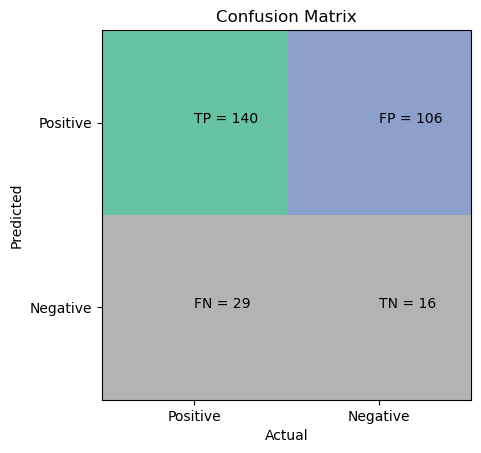

In [47]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

# Now lets try with the whole set

# A. Feature Extraction for 'Key Words'

In [48]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(df['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(df['absolute_tidy_tweets'])

# B. Feature Extraction for 'Key Phrases'

In [49]:
phrase_sents = df['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

In [ ]:
# Model Building: Sentiment Analysis

In [ ]:
# Map target variables to {0, 1}

In [50]:
target_variable = df['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [ ]:
# A. Predictions on 'key words' based features

In [ ]:
# a. BOW word features

Accuracy Score - 0.6331058020477816


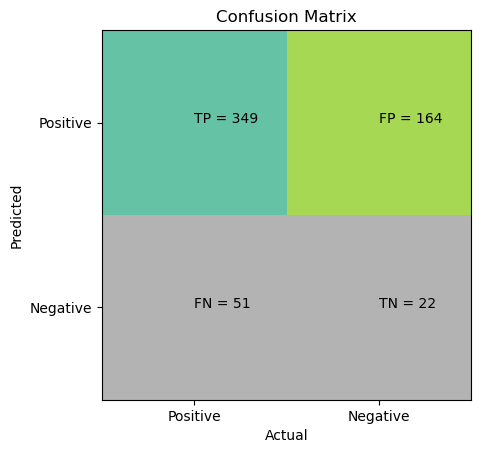

In [51]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

In [ ]:
# b. TF-IDF word features

Accuracy Score - 0.6331058020477816


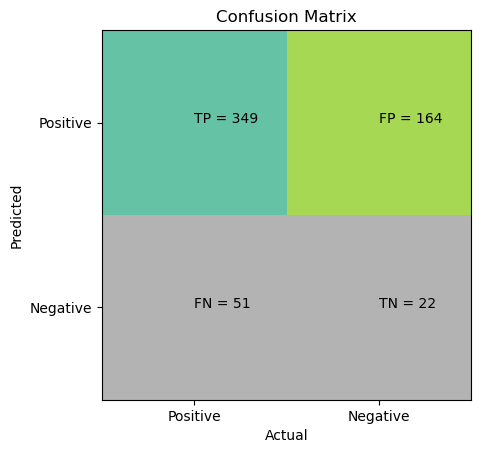

In [52]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

In [ ]:
# B. Predictions on 'key phrases' based features

In [ ]:
# a. BOW Phrase features

Accuracy Score - 0.3242320819112628


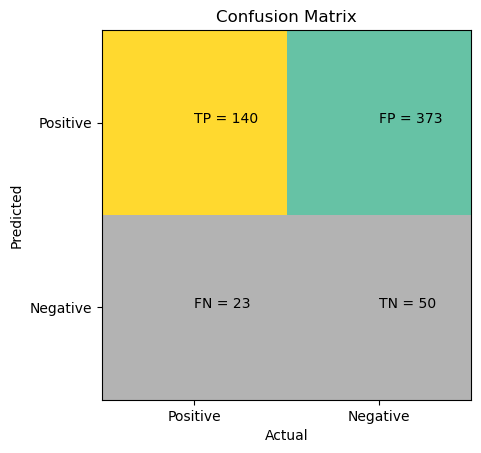

In [53]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

In [ ]:
# b. TF-IDF Phrase features

Accuracy Score - 0.3242320819112628


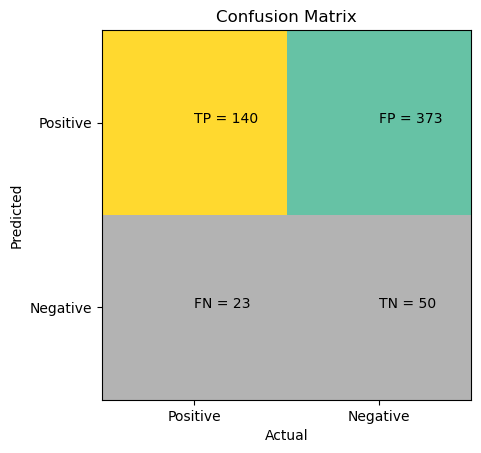

In [54]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)